In [1]:
import os 
os.chdir('../../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.fairness_functions import reshape_general_violent_cond_auc_summaries
from utils.plotting_helpers import safe_save_plt

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa_analysis_all\psa-analysis-public-repo


In [2]:
# read in Broward/Kentucky BNC/BPC data for prediction problems of interest
bpc_bnc_data = {}
for time_period in [
#                     "six-month", 
                    "two-year"
                    ]:
    
#     time_period_formatted = time_period.rel
    for problem in ['general', 'violent']:
#         for region, pn_folder_name in {'broward': "no-condition-pn", 'kentucky': "no-condition-pn"}.items():
        problem_path = "kentucky/fairness/no-condition-pn/" + time_period + "/" + problem
        dircontents = os.listdir()
        if os.path.isdir(problem_path):
            onlyfiles = [f for f in os.listdir(problem_path) if os.path.isfile(os.path.join(problem_path, f))]
        else: 
            continue
        for filename in onlyfiles:
            filename_list = filename.split("-")
            if len(filename_list) == 4: 
                model_name = filename_list[0]
            elif len(filename_list) == 5: 
                model_name = filename_list[0] + "_" + filename_list[1]
            if model_name in ['ebm', 'riskslim', 'riskslim_cs', 'compas', 'arnold']:
                bpc_bnc_data["-".join(("kentucky", problem, time_period, model_name))] = pd.read_csv(problem_path + "/" + filename)

bpc_bnc_data.keys()

dict_keys(['kentucky-general-two-year-arnold', 'kentucky-general-two-year-ebm', 'kentucky-general-two-year-riskslim', 'kentucky-violent-two-year-arnold', 'kentucky-violent-two-year-ebm', 'kentucky-violent-two-year-riskslim'])

In [3]:
bpc_bnc_data['kentucky-violent-two-year-arnold']['Attribute Value'].unique()

array(['Caucasian', 'African-American', 'Other', 'male', 'female'],
      dtype=object)

## BPC and BNC
A score $S$ is **balanced for the positive class** if 
$$
E[S |Y = 1,G = g_i] = E[S |Y = 1,G = g_j],\forall i \neq j \in \alpha.
$$

Similarly, a score $S$ satisfies **balance for negative class** (BNC) if

$$
E[S |Y = 0,G = g_i] = E[S |Y = 0,G = g_j],\forall i \neq j \in \alpha.
$$


## Plot BPC and BNC

In [4]:
def summarize_bpc_bnc_data(bpc_bnc_df:pd.DataFrame,
                           problem_name:str):
    """
    Summarize balance for positive class and negative class output.
    """
    summary = (bpc_bnc_df
                 .drop(columns=["fold_num"])
                 .groupby(["Attribute", "Attribute Value", "Label"])
                 .agg('mean')
                 .reset_index()
                 .replace({"Label": {0: "bnc",
                                     1: "bpc"}})
              )

    summary['Label Name'] = f'{problem_name}_'
    summary['Label'] = summary['Label Name'] + summary['Label']
    del summary['Label Name']

    
    return summary


def reshape_summary(summary):
    """
    """
    new_df = (summary.replace({"Attribute Value": {"African-American": "Afr-Am.",
                                                   "Other": "Other Race",
                                                   "Hispanic": "Hisp.",
                                                   "Caucasian": "Cauc.",
                                                   "female": "Female", 
                                                   "male": "Male"}}))

    wide_df = new_df.pivot(index="Label",
                           columns="Attribute Value",
                           values=["Expected Score"])
    
    col_order = ['Afr-Am.', 'Cauc.', 'Hisp.', "Other Race", "Female", "Male"]
    # check if Kentucky
    if "Hispanic" not in new_df['Attribute Value'].unique():
        col_order = ['Afr-Am.', 'Cauc.', "Other Race", "Female", "Male"]
        
    wide_df = wide_df.T.reindex(col_order, level=1).T

    return wide_df

In [5]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                round(height, 2),
                ha='center', va='bottom')

def plot_bpc_bnc_kentucky(wide_df,
                          model_name:str,
                          region:str,
                          problem:str,
                          save_path=None):
    """
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('ggplot')

    attribute_values = wide_df.columns.get_level_values(1)
    barWidth = 0.12

    bars = {attribute_value: {"bar": None, "pos": None} for attribute_value in attribute_values}
    for attribute_value in attribute_values:
        bars[attribute_value]["bar"] = wide_df[('Expected Score', attribute_value)]
        bar_len = len(bars[attribute_value]["bar"])

    # Set position of bar on X axis
    for i, (bar_name, bar_dict) in enumerate(bars.items()):
        if i == 0:
            bar_dict["pos"] = np.arange(len(bar_dict["bar"]))
        else: 
            prev_bar_pos = bars[prev_bar_name]["pos"]
            bar_dict["pos"] = [x + barWidth for x in prev_bar_pos]
        prev_bar_name = bar_name 

    colors = {"Afr-Am.": 'cornflowerblue',
              "Other Race": 'lightslategrey',
              "Hisp.": 'lightskyblue',
              "Cauc.": 'steelblue',
              "Female": 'lightcoral', 
              "Male": 'pink'}

    for i, (bar_name, bar_dict) in enumerate(bars.items()):
        attr_bars = plt.bar(bar_dict["pos"], 
                      bar_dict["bar"], 
                      color=colors[bar_name], 
                      width=barWidth, 
                      edgecolor='white', 
                      label=f"{bar_name}")
        
        autolabel(attr_bars)

    
    # Add xticks on the middle of the group bars
    xtick_labels = list(wide_df.index)
    plt.xticks(np.arange(len(xtick_labels))+.2, xtick_labels)
    plt.tick_params(axis="x", labelsize=20)

    # y axis formatting
    if model_name == "Arnold": #TODO: Check maxes for general vs violent 
        if problem == "general_two_year":
            plt.ylim(0,8)
            plt.axhline(y=6, color='firebrick', linestyle='--', alpha=.8)
        elif problem == "violent_two_year": 
            plt.ylim(0,8)
            plt.axhline(y=7, color='firebrick', linestyle='--', alpha=.8)            
    else:
        plt.ylim(0,1.05)
        plt.axhline(y=1, color='firebrick', linestyle='--', alpha=.8)

    plt.tick_params(axis="y", labelsize=25)

    plt.legend(fontsize=20, ncol=2, loc='upper right')
    plt.ylabel(f'E({model_name} | Attr = attr, Y = i)', fontsize=25)

    region_cap = region.capitalize()
    plt.title(f"BPC/BNC for {model_name} on \n{problem} in {region_cap}", fontsize = 24)

    if save_path is not None:
        safe_save_plt(plt, save_path)
    plt.show()
    plt.close()
    return


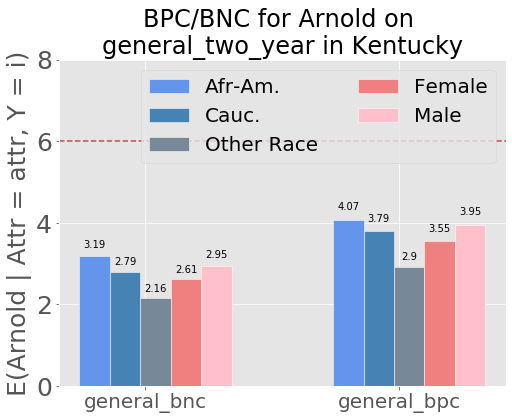

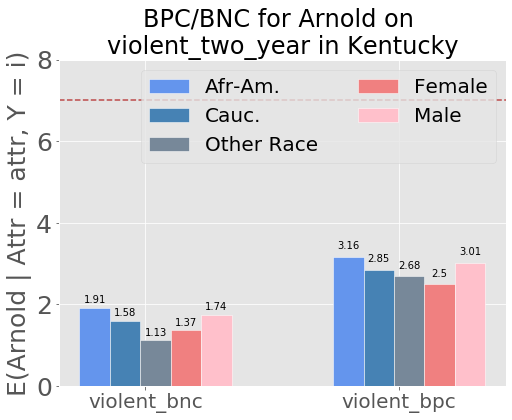

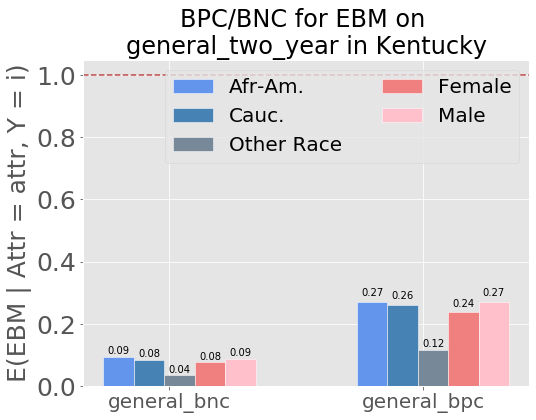

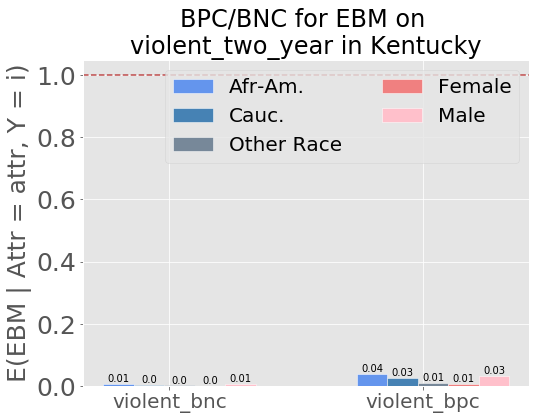

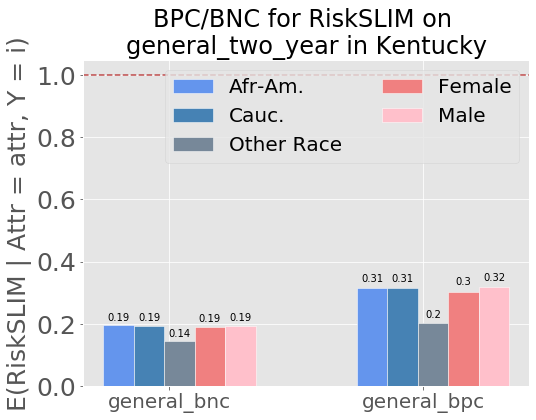

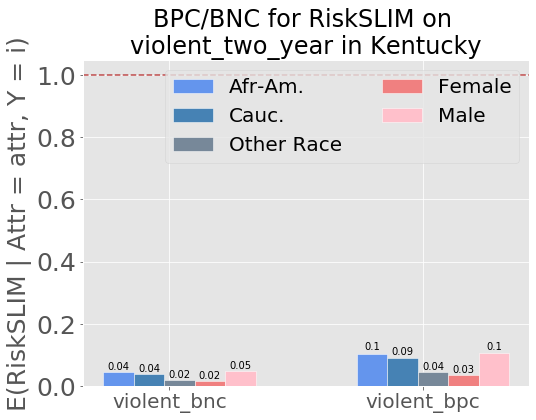

In [6]:
for model_name in [
                   'Arnold', 
                   'EBM', 
                   'RiskSLIM'
                  ]:
    
    model_name_lower = model_name.lower()
    wide_dfs = {"kentucky": None}
    
    if model_name == "RiskSLIM": 
        model_name_lower = "riskslim"    

    general_summary = summarize_bpc_bnc_data(bpc_bnc_df=bpc_bnc_data[f'kentucky-general-two-year-{model_name_lower}'],
                                             problem_name="general")

    violent_summary = summarize_bpc_bnc_data(bpc_bnc_df=bpc_bnc_data[f'kentucky-violent-two-year-{model_name_lower}'],
                                             problem_name="violent")

    general_summary = reshape_summary(general_summary)
    violent_summary = reshape_summary(violent_summary)
    
    plot_bpc_bnc_kentucky(wide_df=general_summary,
                          model_name=model_name,
                          region='kentucky',
                          problem='general_two_year',
                          save_path=f"kentucky/logs/fairness_results/bpc_bnc_visualizations/{model_name_lower}_bpcbnc_general_two_year.pdf"
                          )
    plot_bpc_bnc_kentucky(wide_df=violent_summary,
                          model_name=model_name,
                          region='kentucky',
                          problem='violent_two_year',
                          save_path=f"kentucky/logs/fairness_results/bpc_bnc_visualizations/{model_name_lower}_bpcbnc_violent_two_year.pdf"
                          )

